<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W1/ungraded_labs/C4_W1_Lab_2_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Statistical Forecasting on Synthetic Data

In this lab, you will be doing some statistical forecasting so you can compare it with the machine learning models you will build later on.

## Imports

You will first import the packages you will need to execute all the code in this lab. You will use:
* [Tensorflow](https://www.tensorflow.org/api_docs/python/tf) to build your model and prepare data windows
* [Numpy](https://numpy.org/) for numerical processing
* and Matplotlib's [PyPlot](https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.html) library for visualization

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Utilities

You will then define some utility functions to make the code more organized. First up is the plotting function you also used in the previous lab.

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

You will also place the functions to generate your synthetic data here. For this lab, you will just need trend, seasonality, and noise. Feel free to add others later in case you want a more challenging task.

In [3]:
def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

## Generate the synthetic data

You can then use the utility functions above to generate the synthetic data. This will start at a baseline then trend upwards with a seasonal pattern every 365 steps. You will also add some noise because real world data is often noisy as well.

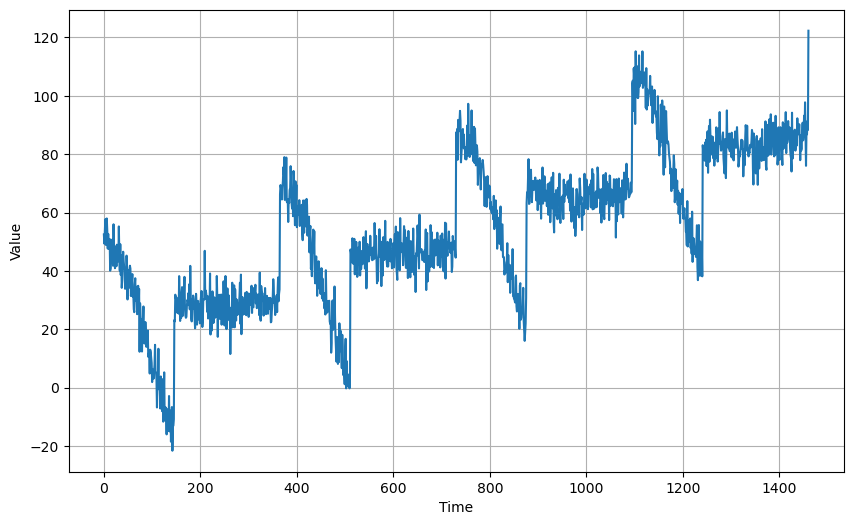

In [4]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

## Split the Dataset

Next up, you will split the data above into training and validation sets. You will take the first 1,000 points for training while the rest is for validation.

In [5]:
# Define the split time
split_time = 1000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

You can inspect these sets visually by using the same utility function for plotting. Notice that in general, the validation set has higher values (i.e. y-axis) than those in the training set. Your model should be able to predict those values just by learning from the trend and seasonality of the training set.

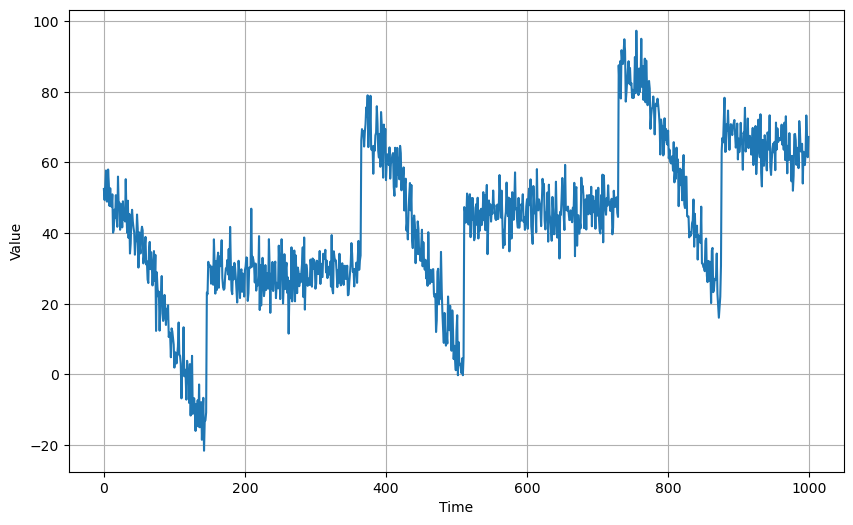

In [6]:
# Plot the train set
plot_series(time_train, x_train)

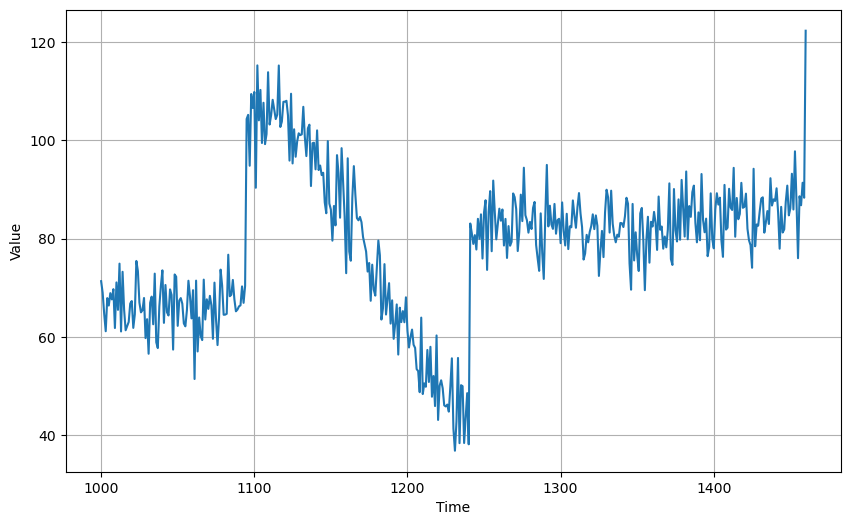

In [7]:
# Plot the validation set
plot_series(time_valid, x_valid)

# Naive Forecast

As a baseline, you can do a naive forecast where you assume that the next value will be the same as the previous time step. You can slice the original series like below and print some values as a sanity check. The next time step value should be identical to the ground truth at the previous time step.

In [8]:
# Generate the naive forecast
naive_forecast = series[split_time - 1:-1]

# Define time step
time_step = 100

# Print values
print(f'ground truth at time step {time_step}: {x_valid[time_step]}')
print(f'prediction at time step {time_step + 1}: {naive_forecast[time_step + 1]}')

ground truth at time step 100: 109.84197998046875
prediction at time step 101: 109.84197998046875


You can see this visually with the `plot_series()` function you defined earlier.

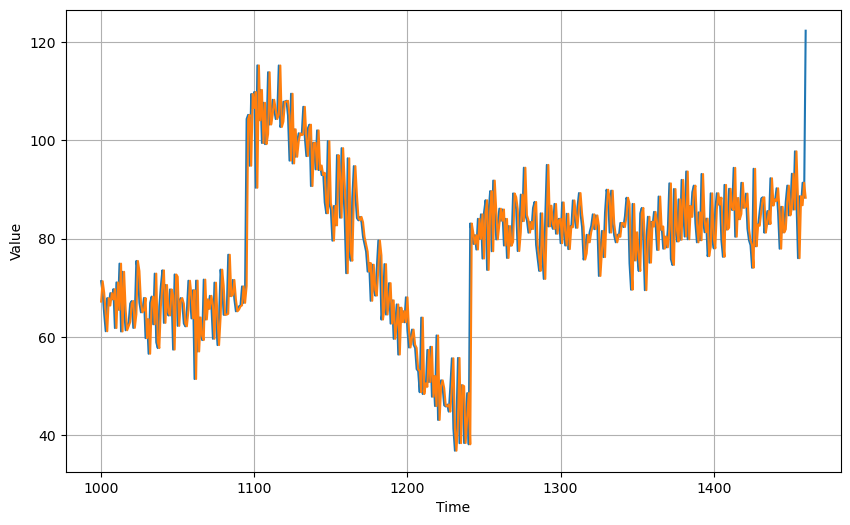

In [9]:
# Plot the results
plot_series(time_valid, (x_valid, naive_forecast))

You can zoom in at the start of the validation period to see that the naive forecast lags 1 step behind the time series.

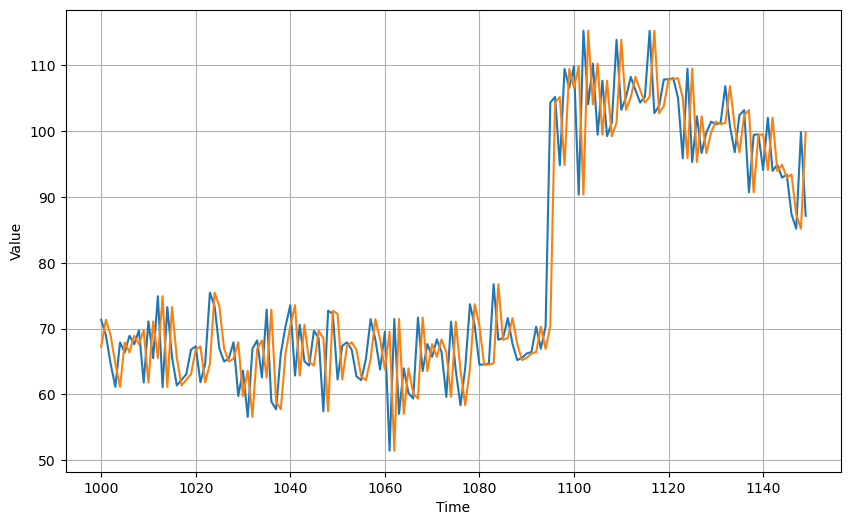

In [10]:
# Zooming in
plot_series(time_valid, (x_valid, naive_forecast), start=0, end=150)

### Computing Metrics

Now you will compute the [mean squared error](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/mean_squared_error) and the [mean absolute error](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/mean_absolute_error) between the forecasts and the predictions in the validation period. These are available via the [`tf.keras.metrics`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/) API.

In [11]:
print(tf.keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

61.827534
5.9379086


The values above will be your baseline and you will see if you can use other methods to do better than naive forecasting.

## Moving Average

One technique you can use is to do a moving average. This sums up a series of time steps and the average will be the prediction for the next time step. For example, the average of the measurements at time steps 1 to 10 will be the forecast for time step 11, then the average for time steps 2 to 11 will be the forecast for time step 12, and so on.

The function below does the moving average for the entire `series`. It takes a `window_size` argument to indicate the number of time steps to consider when computing the mean.

In [12]:
def moving_average_forecast(series, window_size):
    """Generates a moving average forecast

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to compute the average for

    Returns:
      forecast (array of float) - the moving average forecast
    """

    # Initialize a list
    forecast = []

    # Compute the moving average based on the window size
    for time in range(len(series) - window_size):
      forecast.append(series[time:time + window_size].mean())

    # Convert to a numpy array
    forecast = np.array(forecast)

    return forecast

You will use this function to generate the forecast with a window size of `30`.

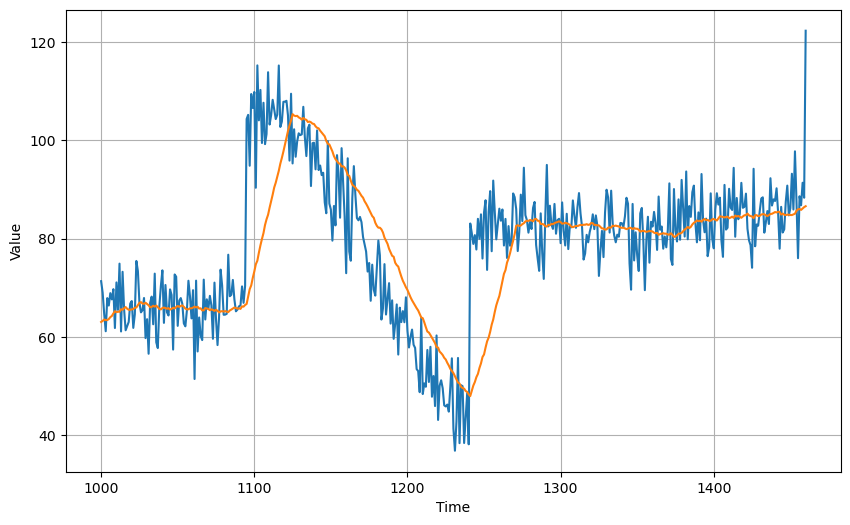

In [13]:
# Generate the moving average forecast split_time = 1000
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

# Plot the results
plot_series(time_valid, (x_valid, moving_avg))

In [14]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

106.674576
7.142419


That's worse than naive forecast! The moving average does not anticipate trend or seasonality. In particular, those huge spikes in the original series causes big deviations as shown in the plot above. You will try to remove these characteristics of the dataset with time differencing and see if you get better results.

## Differencing

Since the seasonality period is 365 days, you will subtract the value at time *t* – 365 from the value at time *t*. That is done with the code below.

In addition, you will need to align the result with the `time` array. Since you can only do time differencing for `t >= 365`, you will need to truncate the first 365 time steps of the `time` array.

You can plot the result to visualize the values.

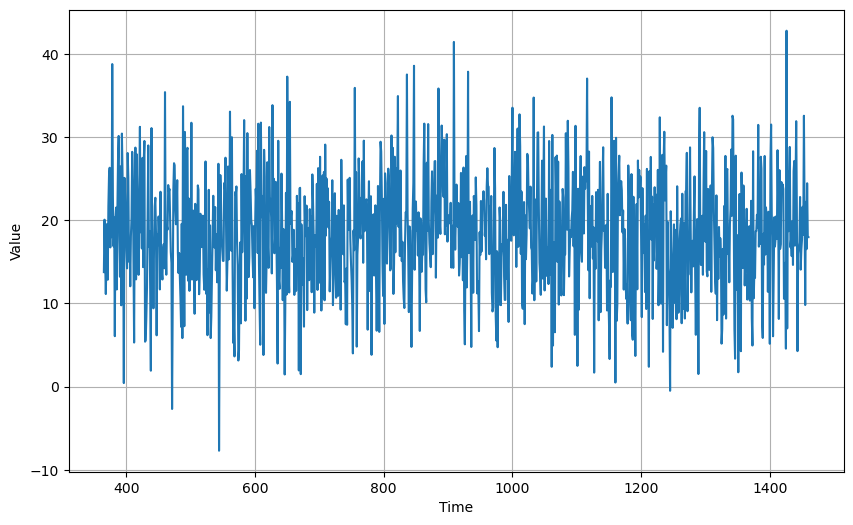

In [15]:
# Subtract the values at t-365 from original series
diff_series = (series[365:] - series[:-365])

# Truncate the first 365 time steps
diff_time = time[365:]

# Plot the results
plot_series(diff_time, diff_series)

Great! The trend and seasonality seem to be gone so now you can retry using the moving average. `diff_series` is the ground truth while `diff_moving_avg` is the prediction array. You will slice these accordingly to correspond to the validation set time steps before comparing.

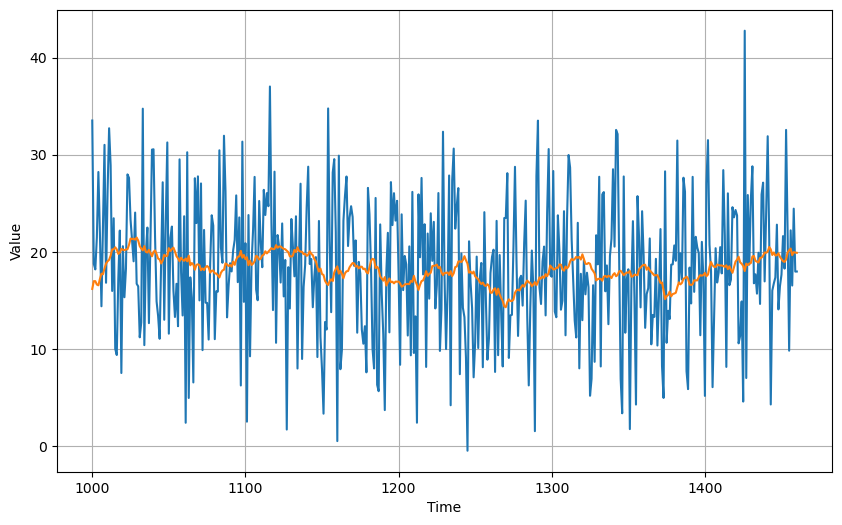

In [16]:
# Generate moving average from the time differenced dataset
diff_moving_avg = moving_average_forecast(diff_series, 30)

# Slice the prediction points that corresponds to the validation set time steps
diff_moving_avg = diff_moving_avg[split_time - 365 - 30:]

# Slice the ground truth points that corresponds to the validation set time steps
diff_series = diff_series[split_time - 365:]

# Plot the results
plot_series(time_valid, (diff_series, diff_moving_avg))

Now you will bring bring back the trend and seasonality by adding the past values from `t – 365`:

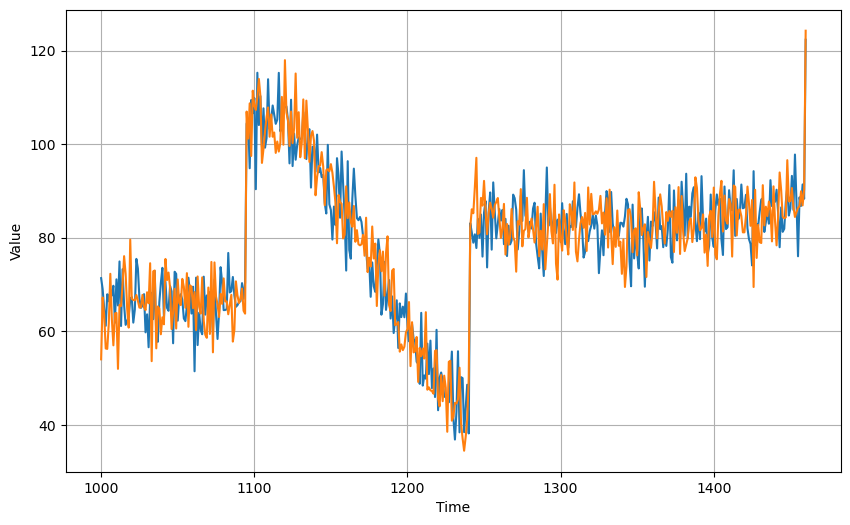

In [17]:
# Add the trend and seasonality from the original series (split_time = 1000)
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

# Plot the results
plot_series(time_valid, (x_valid, diff_moving_avg_plus_past))

In [18]:
print(tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

53.764587
5.9032416


It is a bit better than naive forecast. However, the forecasts look a bit too random because you're adding past values which are already noisy. Remember that the time differenced signal is also noisy so adding these raw past values can compound this problem. To remedy that, you can use a moving averaging on past values to smooth out some of this noise.

## Smoothing

You can use the same `moving_average_forecast()` function to smooth out past values before adding them back to the time differenced moving average. There are two ways to do this:

* Trailing windows - This refers to getting the mean of past values to smooth out the value at the current time step. For example, getting the average of `t=0` to `t=6` to get the smoothed data point at **`t=6`**.

* Centered windows - This refers to getting the mean of past *and future* values to smooth out the value at the current time step. For example, getting the average of `t=0` to `t=6` to get the smoothed data point at **`t=3`**.

The code below will use the centered windows approach and you will notice it in the slicing of the `series` array. It is shifted by `370` steps and the window size is `11`. To get the smooth data point at `t=1000` (i.e. start of the validation set), it will average the measurements at `t=995` to `t=1005`.

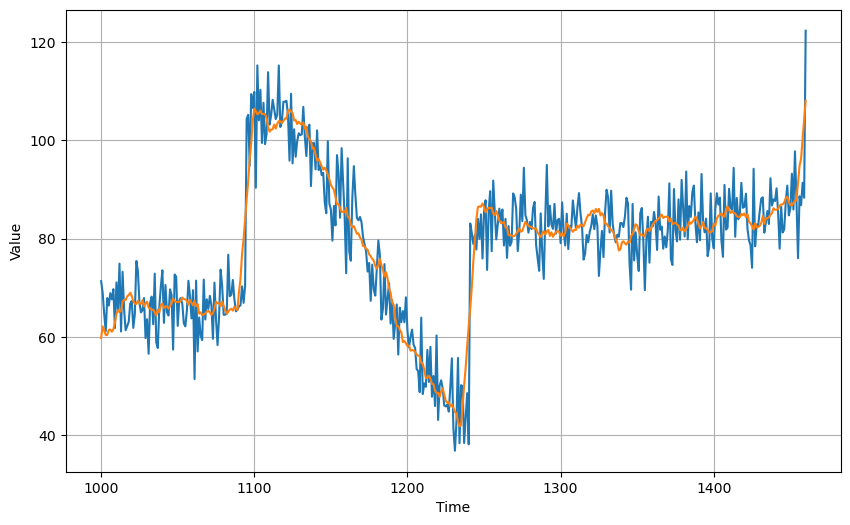

In [19]:
# Smooth the original series before adding the time differenced moving average
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-359], 11) + diff_moving_avg

# Plot the results
plot_series(time_valid, (x_valid, diff_moving_avg_plus_smooth_past))

The metrics will show a big improvement over the previous output.

In [20]:
 # Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

34.315723
4.6053286


## Wrap Up

This concludes a short exploration of statistical methods for time series forecasting. In the next labs, you will build neural networks for forecasting and see if you get comparable results to the techniques you just used in this lab.